# 📈 Week 9 Trading Strategy: Unsupervised Learning

---

## 🎯 Strategy Overview

**Building on Weeks 1-8 + Adding Week 9 Concepts:**
- All prior concepts (ML, Volatility, Factor Models, Instance-Based)
- **NEW:** Principal Component Analysis (PCA) for factor discovery
- **NEW:** K-Means Clustering for market regime detection
- **NEW:** Hierarchical Clustering for asset grouping
- **NEW:** Anomaly Detection for unusual market conditions

**Strategy Logic:**
1. Use PCA to identify latent market factors
2. Cluster market conditions into regimes
3. Detect anomalies (potential opportunities or risks)
4. Generate regime-aware trading signals

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 3
N_CLUSTERS = 4
N_COMPONENTS = 3

print("=" * 60)
print("📊 WEEK 9 TRADING STRATEGY: UNSUPERVISED LEARNING")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Market Regimes: {N_CLUSTERS}")

📊 WEEK 9 TRADING STRATEGY: UNSUPERVISED LEARNING

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📅 Market Regimes: 4


In [2]:
# ============================================================
# DATA LOADING & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading market data...
✅ Loaded 756 trading days


---

## 📊 Section 1: Principal Component Analysis (Week 9 Concept)

**PCA discovers latent factors:**
- PC1: Usually market factor (all stocks move together)
- PC2+: Sector/style rotations

**Dimensionality reduction preserves most variance!**

In [3]:
# ============================================================
# PCA ANALYSIS
# ============================================================

# Standardize returns
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns[TICKERS])

# Fit PCA
pca = PCA(n_components=len(TICKERS))
pca_transformed = pca.fit_transform(returns_scaled)

# Component loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(TICKERS))],
    index=TICKERS
)

# Explained variance
explained_var = pca.explained_variance_ratio_

print("📊 PCA ANALYSIS RESULTS")
print("=" * 70)
print(f"\n📈 EXPLAINED VARIANCE BY COMPONENT:")
for i, var in enumerate(explained_var):
    print(f"   PC{i+1}: {var:.2%} (Cumulative: {sum(explained_var[:i+1]):.2%})")

print(f"\n📊 FACTOR LOADINGS:")
print(loadings.round(3).to_string())

📊 PCA ANALYSIS RESULTS

📈 EXPLAINED VARIANCE BY COMPONENT:
   PC1: 61.42% (Cumulative: 61.42%)
   PC2: 12.52% (Cumulative: 73.94%)
   PC3: 10.76% (Cumulative: 84.70%)
   PC4: 7.94% (Cumulative: 92.64%)
   PC5: 7.36% (Cumulative: 100.00%)

📊 FACTOR LOADINGS:
         PC1    PC2    PC3    PC4    PC5
AAPL   0.403  0.814 -0.352 -0.217  0.066
MSFT   0.466 -0.172 -0.370  0.727 -0.297
GOOGL  0.431  0.193  0.837  0.087 -0.263
AMZN   0.476 -0.267  0.077  0.012  0.834
META   0.456 -0.447 -0.184 -0.645 -0.377


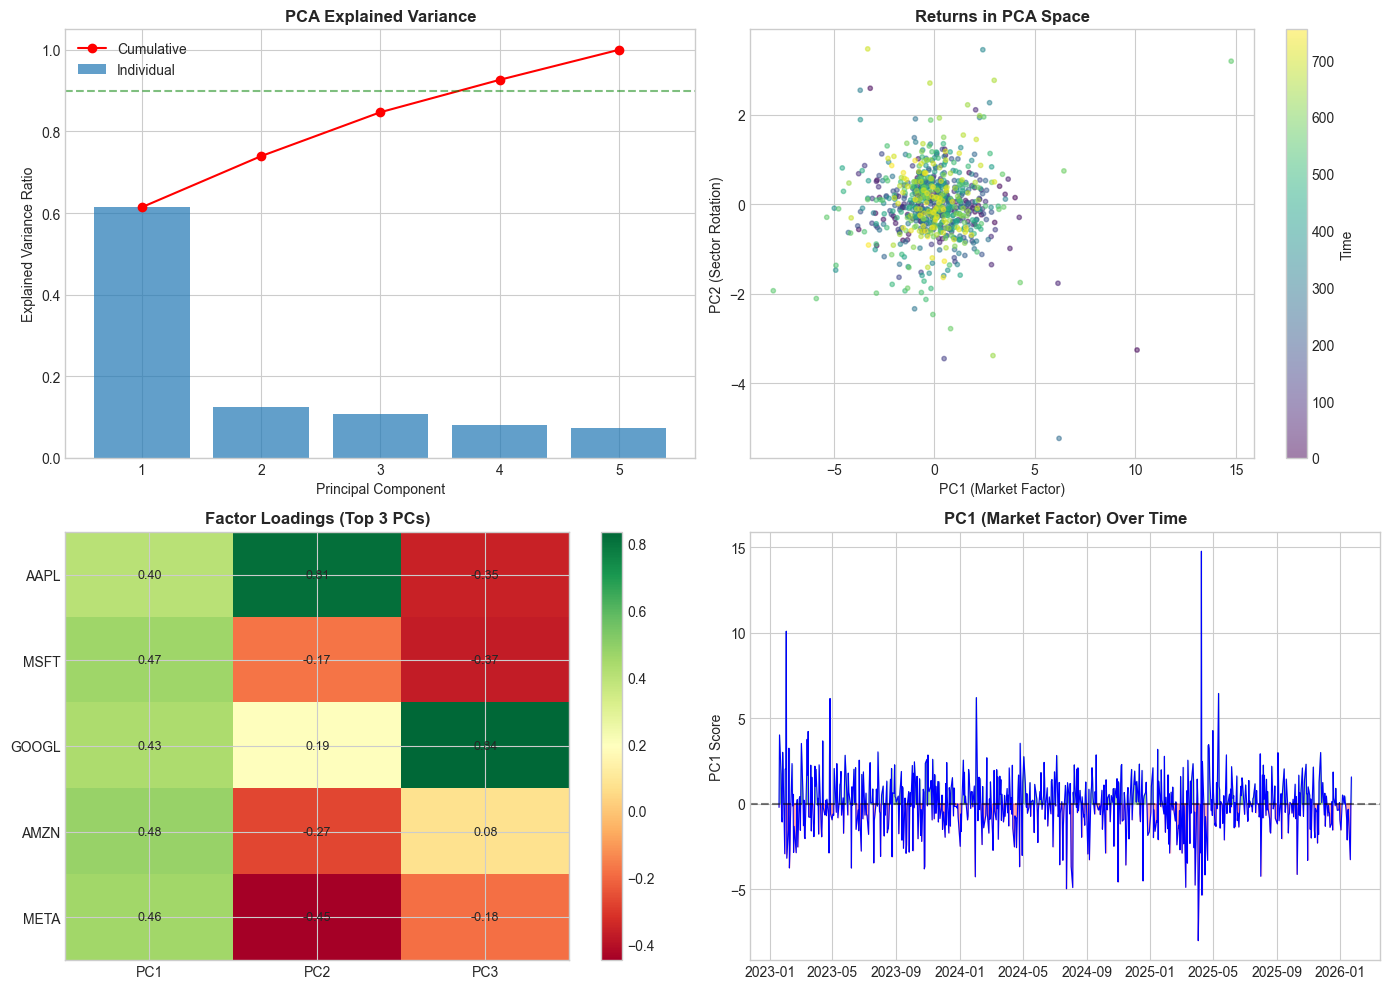

In [4]:
# ============================================================
# PCA VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Explained Variance
ax1 = axes[0, 0]
ax1.bar(range(1, len(explained_var)+1), explained_var, alpha=0.7, label='Individual')
ax1.plot(range(1, len(explained_var)+1), np.cumsum(explained_var), 'ro-', label='Cumulative')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('PCA Explained Variance', fontsize=12, fontweight='bold')
ax1.legend()
ax1.axhline(y=0.9, color='g', linestyle='--', alpha=0.5, label='90% threshold')

# 2. PC1 vs PC2 Scatter
ax2 = axes[0, 1]
pc_df = pd.DataFrame(pca_transformed[:, :2], columns=['PC1', 'PC2'], index=returns.index)
scatter = ax2.scatter(pc_df['PC1'], pc_df['PC2'], c=range(len(pc_df)), cmap='viridis', alpha=0.5, s=10)
ax2.set_xlabel('PC1 (Market Factor)')
ax2.set_ylabel('PC2 (Sector Rotation)')
ax2.set_title('Returns in PCA Space', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax2, label='Time')

# 3. Factor Loadings Heatmap
ax3 = axes[1, 0]
im = ax3.imshow(loadings.values[:, :3], cmap='RdYlGn', aspect='auto')
ax3.set_yticks(range(len(TICKERS)))
ax3.set_yticklabels(TICKERS)
ax3.set_xticks(range(3))
ax3.set_xticklabels(['PC1', 'PC2', 'PC3'])
ax3.set_title('Factor Loadings (Top 3 PCs)', fontsize=12, fontweight='bold')
for i in range(len(TICKERS)):
    for j in range(3):
        ax3.text(j, i, f'{loadings.iloc[i, j]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im, ax=ax3)

# 4. PC1 Time Series
ax4 = axes[1, 1]
pc1 = pd.Series(pca_transformed[:, 0], index=returns.index)
ax4.plot(pc1, 'b-', linewidth=0.8)
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax4.fill_between(pc1.index, 0, pc1, where=pc1>0, alpha=0.3, color='green')
ax4.fill_between(pc1.index, 0, pc1, where=pc1<0, alpha=0.3, color='red')
ax4.set_ylabel('PC1 Score')
ax4.set_title('PC1 (Market Factor) Over Time', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 📊 Section 2: K-Means Market Regime Clustering (Week 9 Concept)

**Identify distinct market regimes:**
- Use return and volatility features
- Cluster into distinct market states
- Each regime has different risk/return characteristics

**Regime-based strategy adapts to market conditions!**

In [5]:
# ============================================================
# MARKET REGIME CLUSTERING
# ============================================================

# Create regime features
regime_features = pd.DataFrame(index=returns.index)
regime_features['market_return'] = returns[BENCHMARK]
regime_features['market_vol'] = returns[BENCHMARK].rolling(20).std()
regime_features['pc1'] = pca_transformed[:, 0]
regime_features['pc2'] = pca_transformed[:, 1]
regime_features = regime_features.dropna()

# Scale features
regime_scaler = StandardScaler()
regime_scaled = regime_scaler.fit_transform(regime_features)

# K-Means clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
regime_labels = kmeans.fit_predict(regime_scaled)

# Add labels to dataframe
regime_features['regime'] = regime_labels

# Regime statistics
print("📊 MARKET REGIME ANALYSIS")
print("=" * 80)

regime_stats = regime_features.groupby('regime').agg({
    'market_return': ['mean', 'std', 'count'],
    'market_vol': 'mean'
})

print("\n📈 REGIME CHARACTERISTICS:")
print(f"\n{'Regime':<10} {'Avg Return':>15} {'Volatility':>15} {'Frequency':>12} {'Label':>15}")
print("-" * 80)

regime_names = {}
for regime in range(N_CLUSTERS):
    avg_ret = regime_stats.loc[regime, ('market_return', 'mean')] * 252
    avg_vol = regime_stats.loc[regime, ('market_vol', 'mean')] * np.sqrt(252)
    count = regime_stats.loc[regime, ('market_return', 'count')]
    freq = count / len(regime_features)
    
    # Label regimes
    if avg_ret > 0.1 and avg_vol < 0.2:
        label = "🟢 BULL (Low Vol)"
    elif avg_ret > 0 and avg_vol >= 0.2:
        label = "🟡 BULL (High Vol)"
    elif avg_ret <= 0 and avg_vol < 0.2:
        label = "🟠 BEAR (Low Vol)"
    else:
        label = "🔴 BEAR (High Vol)"
    
    regime_names[regime] = label
    print(f"{regime:<10} {avg_ret:>14.2%} {avg_vol:>14.2%} {freq:>11.1%} {label:>15}")

📊 MARKET REGIME ANALYSIS

📈 REGIME CHARACTERISTICS:

Regime          Avg Return      Volatility    Frequency           Label
--------------------------------------------------------------------------------
0                -263.75%         13.45%       19.7% 🟠 BEAR (Low Vol)
1                  25.61%         11.72%       47.4% 🟢 BULL (Low Vol)
2                 183.87%         12.93%       30.2% 🟢 BULL (Low Vol)
3                 164.11%         51.89%        2.7% 🟡 BULL (High Vol)


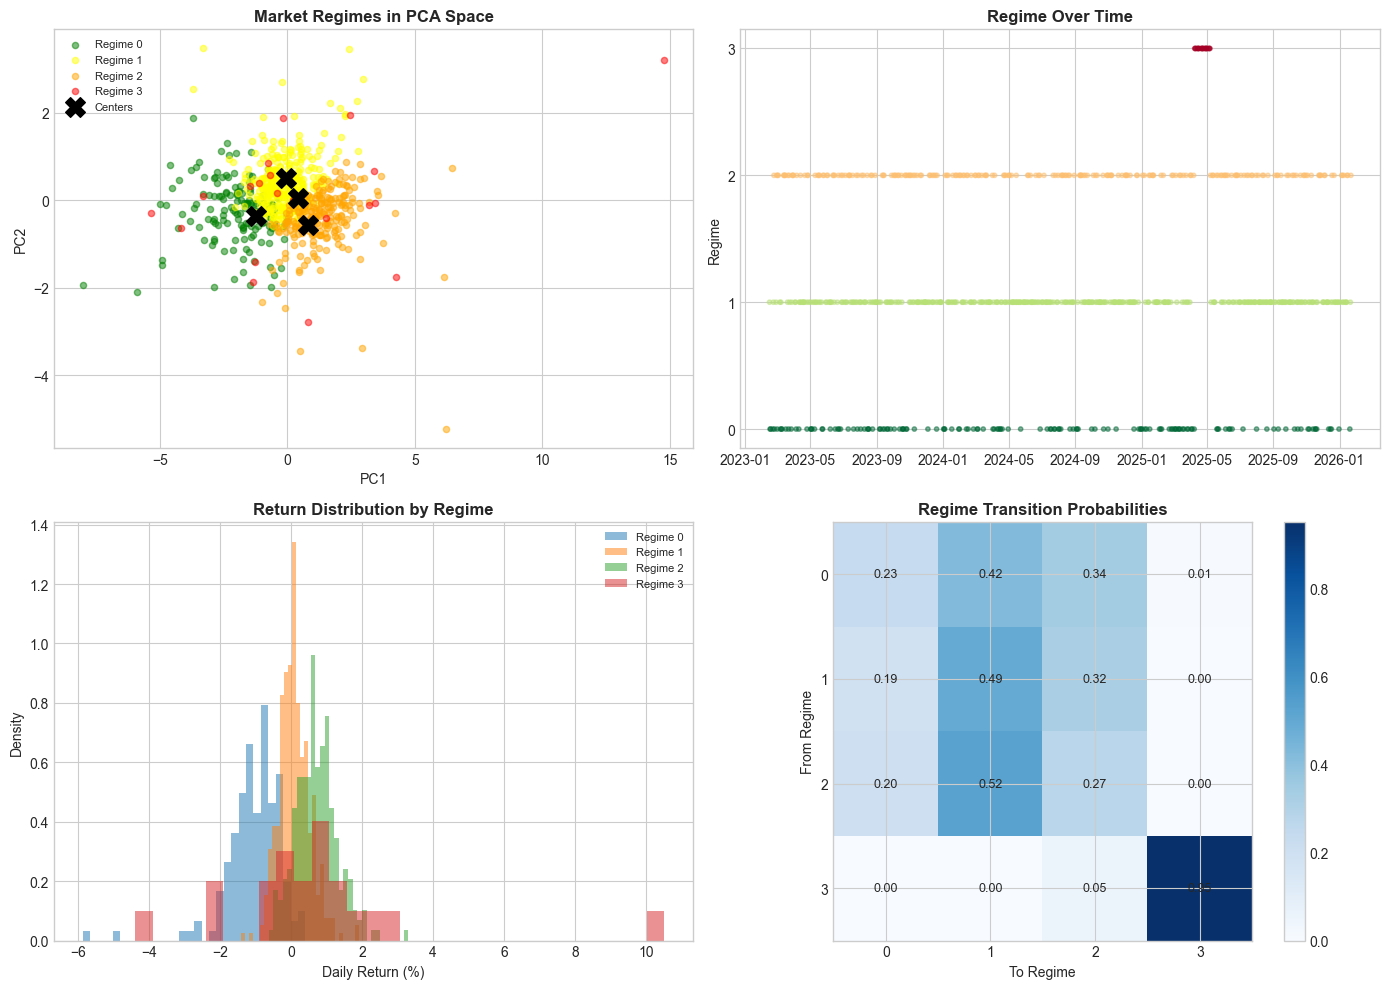

In [6]:
# ============================================================
# REGIME VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Regimes in PC Space
ax1 = axes[0, 0]
colors = ['green', 'yellow', 'orange', 'red']
for regime in range(N_CLUSTERS):
    mask = regime_features['regime'] == regime
    ax1.scatter(regime_features.loc[mask, 'pc1'], regime_features.loc[mask, 'pc2'],
               c=colors[regime], alpha=0.5, s=20, label=f'Regime {regime}')
ax1.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3],
           c='black', marker='X', s=200, label='Centers')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Market Regimes in PCA Space', fontsize=12, fontweight='bold')
ax1.legend(fontsize=8)

# 2. Regime Timeline
ax2 = axes[0, 1]
ax2.scatter(regime_features.index, regime_features['regime'], 
           c=regime_features['regime'], cmap='RdYlGn_r', alpha=0.5, s=10)
ax2.set_ylabel('Regime')
ax2.set_title('Regime Over Time', fontsize=12, fontweight='bold')
ax2.set_yticks(range(N_CLUSTERS))

# 3. Return Distribution by Regime
ax3 = axes[1, 0]
for regime in range(N_CLUSTERS):
    mask = regime_features['regime'] == regime
    data = regime_features.loc[mask, 'market_return'] * 100
    ax3.hist(data, bins=30, alpha=0.5, label=f'Regime {regime}', density=True)
ax3.set_xlabel('Daily Return (%)')
ax3.set_ylabel('Density')
ax3.set_title('Return Distribution by Regime', fontsize=12, fontweight='bold')
ax3.legend(fontsize=8)

# 4. Regime Transition Matrix
ax4 = axes[1, 1]
transitions = np.zeros((N_CLUSTERS, N_CLUSTERS))
for i in range(len(regime_labels)-1):
    transitions[regime_labels[i], regime_labels[i+1]] += 1
transitions = transitions / transitions.sum(axis=1, keepdims=True)

im = ax4.imshow(transitions, cmap='Blues')
ax4.set_xticks(range(N_CLUSTERS))
ax4.set_yticks(range(N_CLUSTERS))
ax4.set_xlabel('To Regime')
ax4.set_ylabel('From Regime')
ax4.set_title('Regime Transition Probabilities', fontsize=12, fontweight='bold')
for i in range(N_CLUSTERS):
    for j in range(N_CLUSTERS):
        ax4.text(j, i, f'{transitions[i,j]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im, ax=ax4)

plt.tight_layout()
plt.show()

---

## 📊 Section 3: Anomaly Detection (Week 9 Concept)

**Isolation Forest detects unusual market conditions:**
- Identifies outlier days
- Unusual patterns = potential opportunities OR risks
- Score indicates how "normal" current market is

**Use anomaly scores for risk management!**

In [7]:
# ============================================================
# ANOMALY DETECTION
# ============================================================

# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_scores = iso_forest.fit_predict(regime_scaled)
anomaly_score_values = iso_forest.decision_function(regime_scaled)

regime_features['anomaly'] = anomaly_scores
regime_features['anomaly_score'] = anomaly_score_values

# Current state
current_regime = regime_features['regime'].iloc[-1]
current_anomaly = regime_features['anomaly'].iloc[-1]
current_anomaly_score = regime_features['anomaly_score'].iloc[-1]

print("📊 ANOMALY DETECTION RESULTS")
print("=" * 70)
print(f"\n📍 CURRENT MARKET STATE:")
print(f"   Regime: {current_regime} ({regime_names[current_regime]})")
print(f"   Anomaly: {'⚠️ ANOMALY DETECTED' if current_anomaly == -1 else '✅ Normal'}")
print(f"   Anomaly Score: {current_anomaly_score:.3f} (higher = more normal)")

# Recent anomalies
recent_anomalies = regime_features[regime_features['anomaly'] == -1].tail(10)
print(f"\n📅 RECENT ANOMALY DAYS ({len(recent_anomalies)} in last period):")
if len(recent_anomalies) > 0:
    for date in recent_anomalies.index[-5:]:
        print(f"   {date.strftime('%Y-%m-%d')}: Score = {regime_features.loc[date, 'anomaly_score']:.3f}")

📊 ANOMALY DETECTION RESULTS

📍 CURRENT MARKET STATE:
   Regime: 2 (🟢 BULL (Low Vol))
   Anomaly: ✅ Normal
   Anomaly Score: 0.200 (higher = more normal)

📅 RECENT ANOMALY DAYS (10 in last period):
   2025-05-07: Score = -0.072
   2025-05-12: Score = -0.102
   2025-07-31: Score = -0.043
   2025-10-10: Score = -0.005
   2025-10-30: Score = -0.024


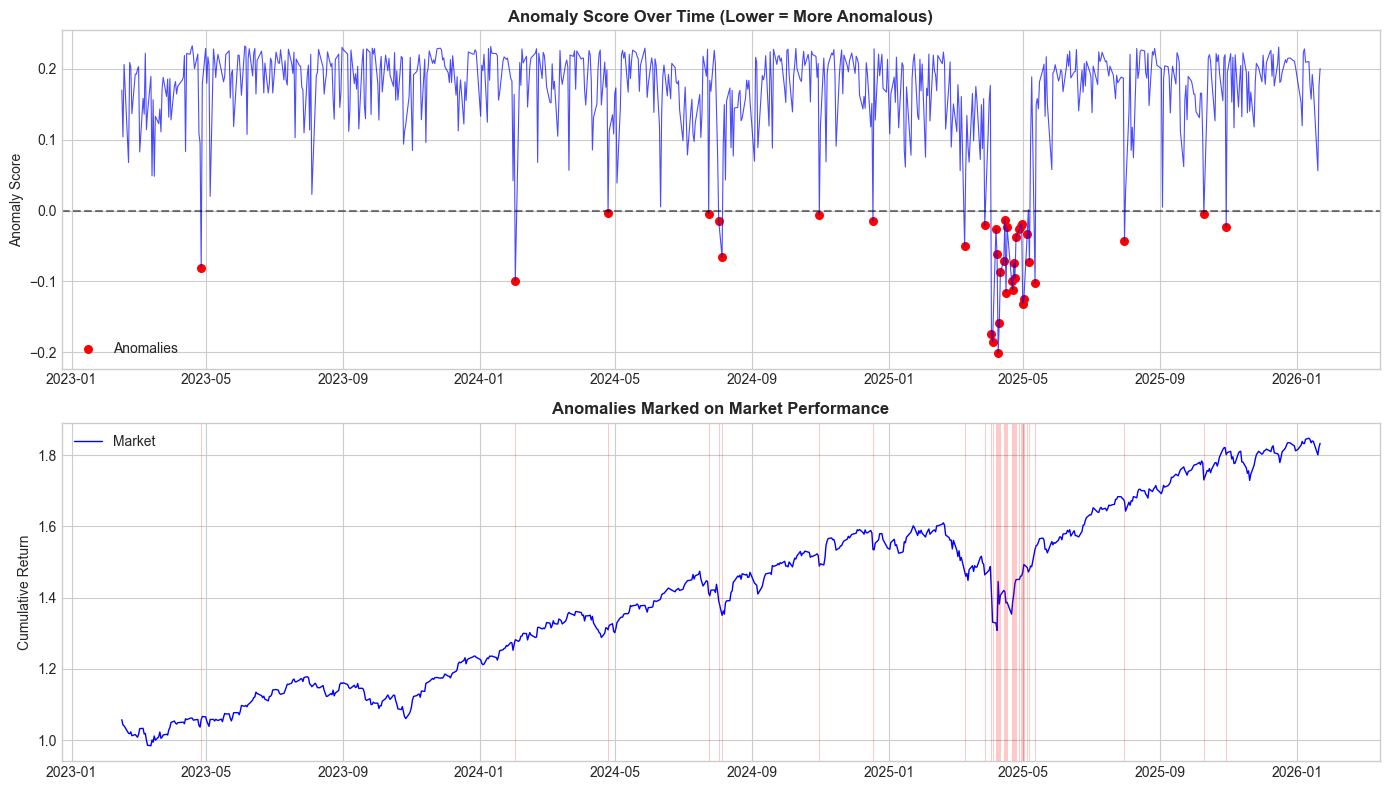

In [8]:
# ============================================================
# ANOMALY VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 1. Anomaly Score Over Time
ax1 = axes[0]
ax1.plot(regime_features.index, regime_features['anomaly_score'], 'b-', linewidth=0.8, alpha=0.7)
anomaly_dates = regime_features[regime_features['anomaly'] == -1].index
ax1.scatter(anomaly_dates, regime_features.loc[anomaly_dates, 'anomaly_score'], 
           c='red', s=30, label='Anomalies')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax1.set_ylabel('Anomaly Score')
ax1.set_title('Anomaly Score Over Time (Lower = More Anomalous)', fontsize=12, fontweight='bold')
ax1.legend()

# 2. Anomaly vs Market Return
ax2 = axes[1]
market_cum = (1 + returns[BENCHMARK]).cumprod()
ax2.plot(market_cum.loc[regime_features.index], 'b-', linewidth=1, label='Market')
# Mark anomaly days
for date in anomaly_dates:
    if date in market_cum.index:
        ax2.axvline(x=date, color='red', alpha=0.3, linewidth=0.5)
ax2.set_ylabel('Cumulative Return')
ax2.set_title('Anomalies Marked on Market Performance', fontsize=12, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# REGIME-BASED TRADING SIGNALS
# ============================================================

print("\n📊 REGIME-BASED TRADING SIGNALS")
print("=" * 80)

# Current regime strategy
current_regime = regime_features['regime'].iloc[-1]

# Strategy by regime
regime_strategies = {
    0: {'strategy': 'AGGRESSIVE LONG', 'weight': 1.5},
    1: {'strategy': 'CAUTIOUS LONG', 'weight': 1.0},
    2: {'strategy': 'DEFENSIVE', 'weight': 0.5},
    3: {'strategy': 'RISK-OFF', 'weight': 0.25}
}

# Match regime to strategy based on characteristics
sorted_regimes = sorted(
    range(N_CLUSTERS),
    key=lambda r: regime_stats.loc[r, ('market_return', 'mean')],
    reverse=True
)

# Reassign strategies
final_strategies = {}
strategy_list = ['AGGRESSIVE LONG', 'CAUTIOUS LONG', 'DEFENSIVE', 'RISK-OFF']
weight_list = [1.5, 1.0, 0.5, 0.25]

for i, regime in enumerate(sorted_regimes):
    final_strategies[regime] = {'strategy': strategy_list[i], 'weight': weight_list[i]}

# Generate signals per ticker
print(f"\n📍 CURRENT REGIME: {current_regime} ({regime_names[current_regime]})")
print(f"📍 RECOMMENDED STRATEGY: {final_strategies[current_regime]['strategy']}")
print(f"📍 POSITION WEIGHT: {final_strategies[current_regime]['weight']:.2f}x")

# Per-ticker signals
print(f"\n{'Ticker':<10} {'PC1 Loading':>12} {'Regime Signal':>15} {'Position':>12}")
print("-" * 80)

trading_signals = {}
base_weight = final_strategies[current_regime]['weight']

for ticker in TICKERS:
    pc1_loading = loadings.loc[ticker, 'PC1']
    
    # Adjust based on PC1 loading
    if pc1_loading > 0.5:
        signal = 'MARKET BETA'
        position = base_weight
    elif pc1_loading < 0.3:
        signal = 'LOW CORR'
        position = base_weight * 0.8
    else:
        signal = 'MODERATE'
        position = base_weight * 0.9
    
    trading_signals[ticker] = {
        'pc1_loading': pc1_loading,
        'signal': signal,
        'position': position
    }
    
    print(f"{ticker:<10} {pc1_loading:>11.2f} {signal:>15} {position:>11.2f}x")


📊 REGIME-BASED TRADING SIGNALS

📍 CURRENT REGIME: 2 (🟢 BULL (Low Vol))
📍 RECOMMENDED STRATEGY: AGGRESSIVE LONG
📍 POSITION WEIGHT: 1.50x

Ticker      PC1 Loading   Regime Signal     Position
--------------------------------------------------------------------------------
AAPL              0.40        MODERATE        1.35x
MSFT              0.47        MODERATE        1.35x
GOOGL             0.43        MODERATE        1.35x
AMZN              0.48        MODERATE        1.35x
META              0.46        MODERATE        1.35x


In [10]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 9 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Summary
print("\n📋 UNSUPERVISED LEARNING ANALYSIS:")

# PCA insights
print(f"\n🔬 PCA INSIGHTS:")
print(f"   PC1 explains {explained_var[0]:.1%} of variance (market factor)")
print(f"   Top 3 PCs explain {sum(explained_var[:3]):.1%} of variance")
highest_loading = loadings['PC1'].idxmax()
print(f"   Highest PC1 loading: {highest_loading} ({loadings.loc[highest_loading, 'PC1']:.2f})")

# Regime insights
print(f"\n🎯 REGIME INSIGHTS:")
print(f"   Current Regime: {current_regime} ({regime_names[current_regime]})")
print(f"   Strategy: {final_strategies[current_regime]['strategy']}")
print(f"   Base Position: {final_strategies[current_regime]['weight']:.2f}x")

# Anomaly insights
print(f"\n⚠️ ANOMALY INSIGHTS:")
if current_anomaly == -1:
    print(f"   WARNING: Current market is ANOMALOUS!")
    print(f"   Consider reducing position sizes or hedging")
else:
    print(f"   Market conditions are NORMAL")
    print(f"   Anomaly score: {current_anomaly_score:.3f}")

# Final positions
print("\n📊 RECOMMENDED POSITIONS:")
for ticker in TICKERS:
    pos = trading_signals[ticker]['position']
    signal_emoji = "📈" if pos > 1 else ("⚪" if pos > 0.5 else "📉")
    print(f"   {ticker}: {pos:.2f}x {signal_emoji}")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 9 STRATEGY - FINAL RECOMMENDATIONS

📋 UNSUPERVISED LEARNING ANALYSIS:

🔬 PCA INSIGHTS:
   PC1 explains 61.4% of variance (market factor)
   Top 3 PCs explain 84.7% of variance
   Highest PC1 loading: AMZN (0.48)

🎯 REGIME INSIGHTS:
   Current Regime: 2 (🟢 BULL (Low Vol))
   Strategy: AGGRESSIVE LONG
   Base Position: 1.50x

⚠️ ANOMALY INSIGHTS:
   Market conditions are NORMAL
   Anomaly score: 0.200

📊 RECOMMENDED POSITIONS:
   AAPL: 1.35x 📈
   MSFT: 1.35x 📈
   GOOGL: 1.35x 📈
   AMZN: 1.35x 📈
   META: 1.35x 📈

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-9)

| Week | Concept | Application |
|------|---------|-------------|
| 1-8 | Prior Concepts | Feature engineering |
| **9** | **PCA** | **Latent factor discovery** |
| **9** | **K-Means** | **Market regime detection** |
| **9** | **Hierarchical Clustering** | **Asset grouping** |
| **9** | **Isolation Forest** | **Anomaly detection** |

---